In [1]:
# General Use
import csv
import sys
#import requests
import skimage.io
import os
import glob
import pickle
from IPython.display import display, Image, HTML
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#import cv2
import h5py
import json
import datetime
import time

# TensorFlow
import tensorflow as tf


#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
np.random.seed(42)
print(tf.__version__)

2.0.0


In [2]:
# Keras imports
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Add, Dense, Reshape, Concatenate, Dropout,BatchNormalization, GaussianNoise
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras import regularizers


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# ratings input
ratingsFilePath="gs://gm-vr-input/data/ratings.csv"
# books input
booksFilePath="gs://gm-vr-input/data/ratings.csv"


In [4]:
# load the user configs
with open('conf/conf.json') as f:    
  config = json.load(f)

# config variables
model_name    = config["model"]
weights     = config["weights"]
include_top   = config["include_top"]
train_path    = config["train_path"]
features_path   = config["features_path"]
labels_path   = config["labels_path"]
test_size     = config["test_size"]
results     = config["results"]
model_path    = config["model_path"]

# start time
print ("[STATUS] start time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))
start = time.time()

[STATUS] start time - 2019-12-12 14:53


In [5]:
base_model = VGG16(weights=weights)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
base_model.input

<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>

In [7]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
image_size = (224, 224)

In [8]:
# path to training dataset
train_labels = os.listdir(train_path)

# encode the labels
print ("[INFO] encoding labels...")
le = LabelEncoder()
le.fit([tl for tl in train_labels])

# variables to hold features and labels
features = []
labels   = []
file_map=[]

# loop over all the labels in the folder
count = 1
for i, label in enumerate(train_labels):
  cur_path = train_path + "/" + label
  count = 1
  for image_path in glob.glob(cur_path + "/*.jpg"):
    try:
      img = image.load_img(image_path, target_size=image_size)
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      # extract features  
      feature = model.predict(x)
      flat = feature.flatten()
      features.append(flat)
      labels.append(label)
      file_map.append(image_path)  
      print ("[INFO] processed - " + str(count))
      count += 1
    except:
      pass
  print ("[INFO] completed label - " + label)

# encode the labels using LabelEncoder
le = LabelEncoder()
le_labels = le.fit_transform(labels)

# get the shape of training labels
print ("[STATUS] training labels: {}".format(le_labels))
print ("[STATUS] training labels shape: {}".format(le_labels.shape))

[INFO] encoding labels...
[INFO] processed - 1
[INFO] processed - 2
[INFO] processed - 3
[INFO] processed - 4
[INFO] processed - 5
[INFO] processed - 6
[INFO] processed - 7
[INFO] processed - 8
[INFO] processed - 9
[INFO] processed - 10
[INFO] processed - 11
[INFO] processed - 12
[INFO] processed - 13
[INFO] processed - 14
[INFO] processed - 15
[INFO] processed - 16
[INFO] processed - 17
[INFO] processed - 18
[INFO] processed - 19
[INFO] processed - 20
[INFO] processed - 21
[INFO] processed - 22
[INFO] processed - 23
[INFO] processed - 24
[INFO] processed - 25
[INFO] processed - 26
[INFO] processed - 27
[INFO] processed - 28
[INFO] processed - 29
[INFO] processed - 30
[INFO] processed - 31
[INFO] processed - 32
[INFO] processed - 33
[INFO] processed - 34
[INFO] processed - 35
[INFO] processed - 36
[INFO] processed - 37
[INFO] processed - 38
[INFO] processed - 39
[INFO] processed - 40
[INFO] processed - 41
[INFO] processed - 42
[INFO] processed - 43
[INFO] processed - 44
[INFO] processe

In [9]:
items=pd.DataFrame({'label': labels, 'features': features, 'path': file_map})
items.head()

,label,features,path
0,8119,"[2.9428325, 1.3653524, 0.0, 0.0, 0.76257765, 0...",watches/train/8119/53016-334729812.jpg
1,8119,"[2.6267536, 0.77102214, 0.0, 0.0, 0.8126972, 0...",watches/train/8119/65002-592824102.jpg
2,8119,"[1.3861163, 2.2683668, 0.0, 0.0, 0.81409585, 0...",watches/train/8119/45002508778094.jpg
3,8119,"[5.459259, 3.270679, 0.0, 0.0, 0.59542555, 0.0...",watches/train/8119/676121532398843.jpg
4,8119,"[5.3857975, 4.2224317, 0.0, 0.0, 0.0, 0.0, 0.0...",watches/train/8119/557671296574805.jpg


In [10]:
items.shape


(2412, 3)

In [11]:
items.label.describe()

count     2412
unique      49
top       5529
freq        50
Name: label, dtype: object

In [12]:
items['item_id']=items.index

In [13]:
items

,label,features,path,item_id
0,8119,"[2.9428325, 1.3653524, 0.0, 0.0, 0.76257765, 0...",watches/train/8119/53016-334729812.jpg,0
1,8119,"[2.6267536, 0.77102214, 0.0, 0.0, 0.8126972, 0...",watches/train/8119/65002-592824102.jpg,1
2,8119,"[1.3861163, 2.2683668, 0.0, 0.0, 0.81409585, 0...",watches/train/8119/45002508778094.jpg,2
3,8119,"[5.459259, 3.270679, 0.0, 0.0, 0.59542555, 0.0...",watches/train/8119/676121532398843.jpg,3
4,8119,"[5.3857975, 4.2224317, 0.0, 0.0, 0.0, 0.0, 0.0...",watches/train/8119/557671296574805.jpg,4
...,...,...,...,...
2407,17009,"[0.24703631, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",watches/train/17009/214270_17009-024.jpg,2407
2408,17009,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",watches/train/17009/296301000470319.jpg,2408
2409,17009,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",watches/train/17009/26853637983957.jpg,2409
2410,17009,"[0.071288526, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",watches/train/17009/214270_17009-033.jpg,2410


In [14]:
#use mount point you previously created when setting up the cluster
# Open and read the file from mounted storage
container = "Recommenders"
#inputFilePath = "/dbfs/mnt/{}/{}".format(container, 'ratings.csv') 
inputFilePath="Recommenders/data/ratings.csv"
dataset = pd.read_csv(inputFilePath)
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [15]:
dataset=dataset[dataset.book_id.between(0,2411)]


In [16]:
dataset.rename(columns=({'book_id':'item_id'}), inplace=True)


In [17]:
dataset

,item_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4
...,...,...,...
240933,2411,50130,4
240934,2411,51192,3
240935,2411,52012,3
240936,2411,52322,5


In [18]:
dataset.describe()

,item_id,user_id,rating
count,240938.000000,240938.000000,240938.000000
mean,1205.534179,24627.420627,3.824706
std,695.933953,14984.357458,1.010747
min,1.000000,1.000000,1.000000
25%,603.000000,11691.000000,3.000000
50%,1205.000000,23291.000000,4.000000
75%,1808.000000,37097.000000,5.000000
max,2411.000000,53424.000000,5.000000


In [19]:
train, test = train_test_split(dataset, test_size=0.1, random_state=42)
print (train.head())
print(test.head())

        item_id  user_id  rating
157096     1572     3022       3
157542     1576    32803       5
134319     1344    15524       5
47161       472    33069       5
75473       755    39013       2
        item_id  user_id  rating
57654       577    21759       3
108082     1081    46513       5
84121       842    17881       5
190231     1903    37611       3
84773       848    33357       4


In [20]:
n_users = dataset.user_id.max()
print("Number of users: ", n_users)
n_items = dataset.item_id.max()
print("Number of items: ", n_items)

Number of users:  53424
Number of items:  2411


In [21]:
item_input = Input(shape=[1], name="Item-Input")
embedding_size = 10 #embedding dimensions
item_embedding = Embedding(input_dim=n_items+1, output_dim=embedding_size, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-items")(item_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(input_dim=n_users+1, output_dim=embedding_size, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
model = Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error') # we are trying to approximate a rating, so we use a regression measure: mse

In [22]:
nb_epoch = 100
batch_size = 16

container = "Recommenders/"
outputFilePath=container+"output/"+'dotproduct_model.h5'


checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)

earlystop = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True
                         )

history = model.fit([train.user_id.values, train.item_id.values], train.rating.values,
                    epochs=nb_epoch,
                    #batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history


# outputFilePath = "/dbfs/mnt/{}/{}".format(container, 'dotproduct_model.h5')

model.save(outputFilePath)

Train on 173475 samples, validate on 43369 samples
Epoch 1/100
173056/173475 [============================>.] - ETA: 0s - loss: 13.4307
Epoch 00001: val_loss improved from inf to 8.13438, saving model to Recommenders/output/dotproduct_model.h5
173475/173475 [==============================] - 23s 135us/sample - loss: 13.4171 - val_loss: 8.1344
Epoch 2/100
173120/173475 [============================>.] - ETA: 0s - loss: 4.4183
Epoch 00002: val_loss improved from 8.13438 to 2.69127, saving model to Recommenders/output/dotproduct_model.h5
173475/173475 [==============================] - 23s 132us/sample - loss: 4.4138 - val_loss: 2.6913
Epoch 3/100
173280/173475 [============================>.] - ETA: 0s - loss: 1.8756
Epoch 00003: val_loss improved from 2.69127 to 1.78805, saving model to Recommenders/output/dotproduct_model.h5
173475/173475 [==============================] - 24s 137us/sample - loss: 1.8752 - val_loss: 1.7881
Epoch 4/100
173152/173475 [============================>.] - ET

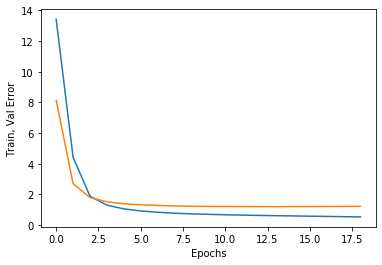

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Train, Val Error")
display()

In [24]:
#concatenate the embeddings
input_vecs = Concatenate()([user_vec, item_vec])
#add a dense layer with regularization
x = Dense(10, activation='relu')(input_vecs)
x = Dropout(0.2)(x)
#add an output layer
y = Dense(1)(x)

model = Model([user_input, item_input], y)
model.compile('adam', 'mean_squared_error')

In [25]:
nb_epoch = 100
batch_size = 16

container = "Recommenders/"
outputFilePath=container+"output/"+'deep_model_1.h5'


checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)

earlystop = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True
                         )

history = model.fit([train.user_id, train.item_id], train.rating,
                    epochs=nb_epoch,
                    #batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history


# outputFilePath = "/dbfs/mnt/{}/{}".format(container, 'dotproduct_model.h5')

model.save(outputFilePath)

Train on 173475 samples, validate on 43369 samples
Epoch 1/100
173248/173475 [============================>.] - ETA: 0s - loss: 1.2181
Epoch 00001: val_loss improved from inf to 0.81986, saving model to Recommenders/output/deep_model_1.h5
173475/173475 [==============================] - 25s 145us/sample - loss: 1.2175 - val_loss: 0.8199
Epoch 2/100
173376/173475 [============================>.] - ETA: 0s - loss: 0.7834
Epoch 00002: val_loss improved from 0.81986 to 0.79210, saving model to Recommenders/output/deep_model_1.h5
173475/173475 [==============================] - 22s 129us/sample - loss: 0.7833 - val_loss: 0.7921
Epoch 3/100
173376/173475 [============================>.] - ETA: 0s - loss: 0.6972
Epoch 00003: val_loss improved from 0.79210 to 0.78440, saving model to Recommenders/output/deep_model_1.h5
173475/173475 [==============================] - 23s 131us/sample - loss: 0.6972 - val_loss: 0.7844
Epoch 4/100
173376/173475 [============================>.] - ETA: 0s - loss: 

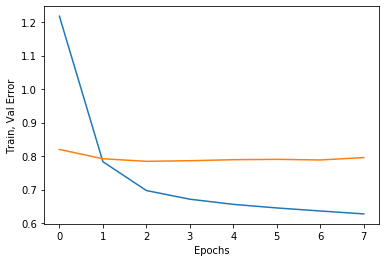

In [26]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Train, Val Error")
display()

In [27]:
new_dataset=dataset.join(items.set_index('item_id'), on='item_id')
new_dataset


,item_id,user_id,rating,label,features,path
0,1,314,5,8119,"[2.6267536, 0.77102214, 0.0, 0.0, 0.8126972, 0...",watches/train/8119/65002-592824102.jpg
1,1,439,3,8119,"[2.6267536, 0.77102214, 0.0, 0.0, 0.8126972, 0...",watches/train/8119/65002-592824102.jpg
2,1,588,5,8119,"[2.6267536, 0.77102214, 0.0, 0.0, 0.8126972, 0...",watches/train/8119/65002-592824102.jpg
3,1,1169,4,8119,"[2.6267536, 0.77102214, 0.0, 0.0, 0.8126972, 0...",watches/train/8119/65002-592824102.jpg
4,1,1185,4,8119,"[2.6267536, 0.77102214, 0.0, 0.0, 0.8126972, 0...",watches/train/8119/65002-592824102.jpg
...,...,...,...,...,...,...
240933,2411,50130,4,17009,"[0.8800237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",watches/train/17009/214270_17009-027.jpg
240934,2411,51192,3,17009,"[0.8800237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",watches/train/17009/214270_17009-027.jpg
240935,2411,52012,3,17009,"[0.8800237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",watches/train/17009/214270_17009-027.jpg
240936,2411,52322,5,17009,"[0.8800237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",watches/train/17009/214270_17009-027.jpg


In [28]:
new_dataset.features[0]

array([2.6267536 , 0.77102214, 0.        , ..., 5.035347  , 0.        ,
       4.01118   ], dtype=float32)

In [29]:
item_input = Input(shape=[1], name="Item-Input")
embedding_size = 10
item_embedding = Embedding(input_dim=n_items+1, output_dim=embedding_size, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(input_dim=n_users+1, output_dim=embedding_size, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

metadata_input=Input(shape=[len(new_dataset.features[0])], name="Metadata-Input")
metadata_vec = Dense(10,
                     #embedding_size,
                     activation='relu', name="Metadata-Embedding")(metadata_input)
#metadata_vec = Flatten(name="Flatten-Metadata")(metadata_embedding)

In [30]:
# new model with metadata and several regularization techniques to prevent overfitting
input_vecs = Concatenate()([user_vec, item_vec, metadata_vec])
#input_vecs = Dropout(0.5)(input_vecs)
#x=BatchNormalization()(input_vecs)
x = Dense(128, activation='relu',
          #kernel_regularizer=regularizers.l2(0.01),
          kernel_initializer='random_normal',
          activity_regularizer=regularizers.l1(10e-4) #to prevent overfitting of training data
         )(input_vecs)
x = Dropout(0.2)(x)
#x=BatchNormalization()(x)
#output layer
y = Dense(1)(x)

new_model = Model([user_input, item_input, metadata_input], y)
new_model.compile('adam', 'mean_squared_error')

In [31]:
#split for training
train, test = train_test_split(new_dataset, test_size=0.1, random_state=42)

In [32]:
np.vstack(train.features).shape


(216844, 4096)

In [33]:
## train new model with sampling
nb_epoch = 100
batch_size = 32

container = "Recommenders/"
outputFilePath=container+"output/"+'deep_model_2.h5'

checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True
                         )

history = new_model.fit([train.user_id, train.item_id, np.vstack(train.features)], train.rating,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history

Train on 173475 samples, validate on 43369 samples
Epoch 1/100
173376/173475 [============================>.] - ETA: 0s - loss: 1.0131
Epoch 00001: val_loss improved from inf to 0.89929, saving model to Recommenders/output/deep_model_2.h5
173475/173475 [==============================] - 30s 170us/sample - loss: 1.0130 - val_loss: 0.8993
Epoch 2/100
173376/173475 [============================>.] - ETA: 0s - loss: 0.8224
Epoch 00002: val_loss improved from 0.89929 to 0.78619, saving model to Recommenders/output/deep_model_2.h5
173475/173475 [==============================] - 29s 167us/sample - loss: 0.8224 - val_loss: 0.7862
Epoch 3/100
173312/173475 [============================>.] - ETA: 0s - loss: 0.7551
Epoch 00003: val_loss improved from 0.78619 to 0.76598, saving model to Recommenders/output/deep_model_2.h5
173475/173475 [==============================] - 29s 166us/sample - loss: 0.7553 - val_loss: 0.7660
Epoch 4/100
173440/173475 [============================>.] - ETA: 0s - loss: 

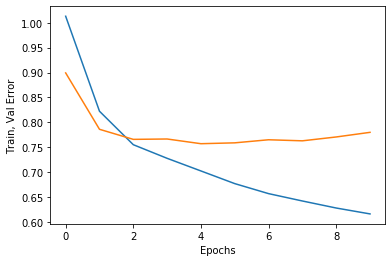

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Train, Val Error")
display()

In [35]:
eval_loss=new_model.evaluate([test.user_id, test.item_id, np.vstack(test.features)], test.rating)
print("Evaluation loss: ", eval_loss)

24094/24094 [==============================] - 1s 44us/sample - loss: 0.7646
Evaluation loss:  0.7646312309942216


In [36]:
## to be done yet: autoencoder with metadata ##

In [37]:
# autoencoder to reduce dimension of feature vector to 10

In [39]:
embedding_size = 10 #embedding dimensions
metadata_input_dim=len(new_dataset.features[0])
encoding_dim=embedding_size
print(metadata_input_dim, encoding_dim)
#from keras.layers import LeakyReLU

4096 10


In [40]:
metadata_input=Input(shape=(metadata_input_dim,), name="Metadata-Input")
encoded=GaussianNoise(stddev=0.1)(metadata_input)
#encoded=Dropout(0.1)(encoded)
encoded=Dense(256, 
              activation='relu'
             )(encoded)
#encoded=LeakyReLU(0.3)(encoded)
encoder=Dense(encoding_dim, 
              activation='relu'
             )(encoded)
#encoder=LeakyReLU(0.3)(encoded)
decoder=Dense(256, 
              activation='relu'
             )(encoder)
#decoder=LeakyReLU(0.3)(decoder)
decoder=Dense(metadata_input_dim, activation='linear')(decoder)

autoencoder=Model(inputs=metadata_input, outputs=decoder)
ae_encoder=Model(inputs=metadata_input, outputs=encoder)

encoded_input=Input(shape=(encoding_dim,))
decoder_layer=autoencoder.layers[-2] # last 2 layers of autoencoder is a decoder
ae_decoder=Model(encoded_input, decoder_layer(encoded_input))

In [41]:
autoencoder.compile(loss='mse', optimizer='adam')

In [42]:
## train autoencoder model with sampling
nb_epoch = 100
batch_size = 32

container = "Recommenders/"
outputFilePath=container+"output/"+'feature_autoencoder_model_1.h5'

checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',
                         patience=10,
                         verbose=1,
                         restore_best_weights=True
                         )

history = autoencoder.fit(np.vstack(train.features), np.vstack(train.features),
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history

Train on 173475 samples, validate on 43369 samples
Epoch 1/100
173408/173475 [============================>.] - ETA: 0s - loss: 0.2175
Epoch 00001: val_loss improved from inf to 0.18191, saving model to Recommenders/output/feature_autoencoder_model_1.h5
173475/173475 [==============================] - 100s 577us/sample - loss: 0.2175 - val_loss: 0.1819
Epoch 2/100
173376/173475 [============================>.] - ETA: 0s - loss: 0.1669
Epoch 00002: val_loss improved from 0.18191 to 0.15908, saving model to Recommenders/output/feature_autoencoder_model_1.h5
173475/173475 [==============================] - 91s 527us/sample - loss: 0.1669 - val_loss: 0.1591
Epoch 3/100
173440/173475 [============================>.] - ETA: 0s - loss: 0.1529
Epoch 00003: val_loss improved from 0.15908 to 0.14917, saving model to Recommenders/output/feature_autoencoder_model_1.h5
173475/173475 [==============================] - 89s 512us/sample - loss: 0.1529 - val_loss: 0.1492
Epoch 4/100
173472/173475 [====

KeyboardInterrupt: 

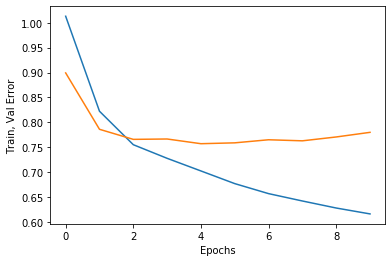

In [43]:
plt.clf()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Train, Val Error")
display()

In [116]:
ae_encoder=load_model('Recommenders/output/feature_autoencoder_model_1.h5')

In [117]:
pretrained_layer=[]
ae_encoder.layers.pop(0)
for layer in ae_encoder.layers:
    #layer.trainable=False
    pretrained_layer.append(layer)
ae_encoder.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Metadata-Input (InputLayer)  [(None, 4096)]            0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2816      
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              1052672   
Total params: 2,106,890
Trainable params: 2,106,890
Non-trainable params: 0
_________________________________________________

In [118]:
pretrained_layer

In [119]:
# stitching it together
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(input_dim=n_items+1, output_dim=embedding_size, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-items")(item_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(input_dim=n_users+1, output_dim=embedding_size, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
#user_vec=Dropout(0.1)(user_vec)

metadata_input=Input(shape=(metadata_input_dim,), name="Metadata-Input")

encoded=GaussianNoise(stddev=0.1)(metadata_input)
encoded=pretrained_layer[1](encoded)
encoded=pretrained_layer[2](encoded)
metadata_vec=pretrained_layer[3](encoded)

item_vec_augmented=Add()([metadata_vec, item_vec])
item_vec_augmented=Dropout(0.1)(item_vec_augmented)
'''
metadata_vec=ae_encoder.get_layer(ae_encoder.layers)(metadata_input)
'''
prod = Dot(name="Dot-Product", axes=1)([item_vec_augmented, user_vec])
cdl_model = Model([user_input, item_input, metadata_input], prod)

In [120]:
def root_mean_squared_error(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true), axis=-1)) 

In [121]:
def evaluation_metric(y_true, y_pred):

    y_true = y_true * tf.keras.backend.cast((y_true != 0),dtype='float32')
    #y_true=y_true[np.nonzero(y_true)]
    y_pred = y_pred * tf.keras.backend.cast((y_true != 0), dtype='float32')
    #y_pred=y_pred[np.nonzero(y_true)]

    error = root_mean_squared_error(y_true, y_pred)
    return error

In [122]:
#cdl_model.compile('adam', 'mean_squared_error') # we are trying to approximate a rating, so we use a regression measure: mse
cdl_model.compile(optimizer='adadelta', 
                  loss=evaluation_metric,
                  metrics=[evaluation_metric])

In [123]:
## train new model with sampling
nb_epoch = 100
batch_size = 32

container = "Recommenders/"
outputFilePath=container+"output/"+'cdl_model_1.h5'

checkpointer = ModelCheckpoint(filepath=outputFilePath,
                               verbose=1,
                               save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss',
                         patience=10,
                         verbose=1,
                         restore_best_weights=True
                         )

history = cdl_model.fit([train.user_id, train.item_id, np.vstack(train.features)], train.rating,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, earlystop]).history

Train on 173475 samples, validate on 43369 samples
Epoch 1/100
173376/173475 [============================>.] - ETA: 0s - loss: 3.8315 - evaluation_metric: 3.8315
Epoch 00001: val_loss improved from inf to 3.82330, saving model to Recommenders/output/cdl_model_1.h5
173475/173475 [==============================] - 59s 343us/sample - loss: 3.8314 - evaluation_metric: 3.8314 - val_loss: 3.8233 - val_evaluation_metric: 3.8233
Epoch 2/100
173376/173475 [============================>.] - ETA: 0s - loss: 3.8266 - evaluation_metric: 3.8266
Epoch 00002: val_loss improved from 3.82330 to 3.82054, saving model to Recommenders/output/cdl_model_1.h5
173475/173475 [==============================] - 63s 361us/sample - loss: 3.8266 - evaluation_metric: 3.8266 - val_loss: 3.8205 - val_evaluation_metric: 3.8205
Epoch 3/100
173408/173475 [============================>.] - ETA: 0s - loss: 3.8257 - evaluation_metric: 3.8257
Epoch 00003: val_loss improved from 3.82054 to 3.81808, saving model to Recommender

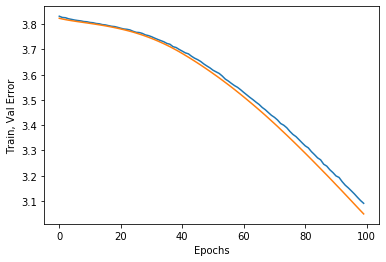

In [124]:
plt.clf()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Train, Val Error")
display()

In [125]:
# Creating dataset for making recommendations for the first user
#watch_data = np.array(list(set(new_dataset.item_id)))
watch_data=np.array(new_dataset.item_id)
picture_data= np.vstack(new_dataset.features)
user_data = np.array([1 for i in range(len(watch_data))])


In [126]:
predictions = cdl_model.predict([user_data, watch_data, np.vstack(picture_data)])

predictions = np.array([a[0] for a in predictions])

recommended_watch_ids = (-predictions).argsort()[:5]

recommended_watch_ids

array([39152, 39126, 39127, 39128, 39129])